### Benchmark results

#### Load modules and code

In [19]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt


fs_map = {
  'nfsv4': 'NFSv4',
  'cephfs': 'CephFS',
  'ganesha': 'NFS Ganesha',
  'rbd': 'Ceph RBD + NFSv4',
  'glusterfs': 'GlusterFS',
  'gfganesha': 'GlusterFS + NFS Ganesha',
  'rbdganesha': 'Ceph RBD + NFS Ganesha'
}

fields = {
  'file_size': 1,
  'block_size': 2,
  'num_client': 3
}

def reject_outliers(data, m=1):
  data = np.array(data)
  return data[abs(data - np.mean(data)) < m * np.std(data)]


def get_dataset(ids=[]):
  if not ids:
    ids = [f for f in os.listdir() if os.path.isdir(f)]
  aggr_data = {}
  for ds_id in ids:
    for fs in os.listdir('%s'%ds_id):
      if not os.path.isdir('%s/%s'%(ds_id, fs)): continue
      for instance in os.listdir('%s/%s'%(ds_id, fs)):
        if not os.path.isdir('%s/%s/%s'%(ds_id, fs, instance)): continue
        instance_dir = '%s/%s/%s'%(ds_id, fs, instance)
        n_cli = len(os.listdir(instance_dir)) - 1
        for f in os.listdir(instance_dir):
          if not f.endswith('.json'): continue
          for rec in json.load(open('%s/%s/%s/%s'%(ds_id, fs, instance, f))):
            file_size, block_size = rec['file_size'], rec['reclen']
            for k, v in rec.items():
              if k in ('file_size', 'reclen'): continue
              aggr_data.setdefault((fs, file_size, block_size, n_cli), {}).setdefault(k, []).append(v)
  return aggr_data


def plot(dataset, x_axis='file_size', test='write', fixed={}, exclude=[]):

  def check_conditions(k, conds):
    return all([k[fields.get(kk)] == vv for kk, vv in conds.items()])

  fno = fields.get(x_axis)
  if not fno:
    sys.stderr.write('Unknown field "%s"'%x_axis)
    sys.exit(1)
  dataset = {k: {kk: vv for kk, vv in v.items() if kk == test}
             for k, v in dataset.items() if check_conditions(k, fixed)}
  data_by_fs, x = {}, set()
  for k, v in dataset.items():
    x_val = k[fno]
    x.add(x_val)
    data_by_fs.setdefault(k[0], {}).setdefault(x_val, []).append(v[test])
  x = np.array(sorted(list(x)))
  for fs, vs in data_by_fs.items():
    if fs in exclude: continue
    # plt.errorbar(np.arange(len(x)), [np.mean(vs[xx]) for xx in x], 
    #              yerr=[np.std(vs[xx]) for xx in x], label=fs_map[fs])
    plt.plot(np.arange(len(x)), [np.mean(vs[xx]) for xx in x], label=fs_map[fs])
  plt.title(', '.join(['test=%s'%test] +
                      ['%s=%d'%(k, v) for k, v in fixed.items()]))
  if x_axis == 'file_size':
    plt.xticks(np.arange(len(x)),
               ['%dK'%xx if xx < 1024 else '%dM'%(xx/1024) for xx in x], rotation=45)
  elif x_axis == 'num_client':
    plt.xticks(np.arange(len(x)), x)
  plt.xlabel(x_axis)
  plt.ylabel('Throughput (KB/s)')
  plt.legend()
  plt.show()

#### 1. Scalability

In this experiment, we compare the throughput of the following storage solutions as the number of concurrent clients increases (1 - 16). 

- NFSv4
- CephFS
- CephRBD + NFS Ganesha
- GlusterFS + NFS Ganesha

All the solutions except the NFSv4 have 3 `n1-standard-4` (4 cores, 15GB RAM) VMs serving as a storage cluster in `us-east1-b` on GCP, each of which has a 100GB disk dedicated for data storage. 

In [14]:
dataset = get_dataset(['ff95ca6b7c3c0b37ffca953f541eaa3d9e6d749a'])

##### 1.1 Write operations

The figures below shows that CephFS outperforms other solutions in write/rewrite operations. It is mainly due to the ability of CephFS to distribute loads across its OSDs. For every client, CephFS assigns a specific OSD and establishes a direct connection between the OSD and the client. Therefore, there is no central point for data transfers and the bandwidth contention is alleviated. In contrast, despite whether the data is distributed at the backend, NFS-based solutions always expose a single point for serving clients and thus tend to cause bandwidth contention. 

Besides, it is also observed in the figures that the throughput drop for rewrites is much less than writes as the number of clients increases. The observation indicates that CephFS incurs significant overhead for creating metadata for new files as the number of clients increases, since the major difference between write and rewirte is whether the metadata pre-exists. The intuition is that the metadata creation incurs a sequence of instant data operations and the initial cost caused by these operations can hardly be amortized. Since CephFS replicates also the metadata, the associated initial cost is larger than that in file systems where metadata is centrally stored.

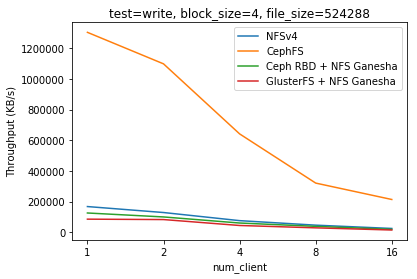

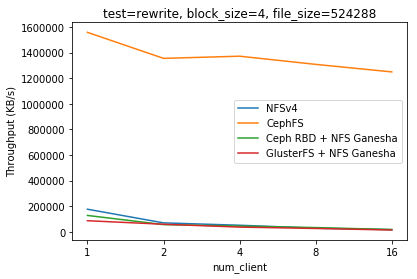

In [20]:
plot(dataset, x_axis='num_client', test='write', fixed=dict(block_size=4, file_size=512 * 1024))
plot(dataset, x_axis='num_client', test='rewrite', fixed=dict(block_size=4, file_size=512 * 1024))

##### 1.2 Read operations

The read performance of the storage cluster solutions are in the same ballpark, but significantly surpasses the NFSv4 solution. This follows the intuition since NFSv4 is not optimized for read operations. In comparison, GlusterFS + NFS Ganesha performs the best in both read and re-read due to two factors: 1) multiple replicas of a file in GlusterFS can accelerate reads since the client can concurrently read from the multiple replicas; 2) the caching policy of NFS Ganesha is aggressive and can facilitate re-reads. 

It is surprising that the re-read performance of NFSv4 improves as the number of clients increases

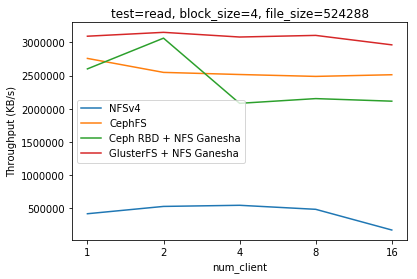

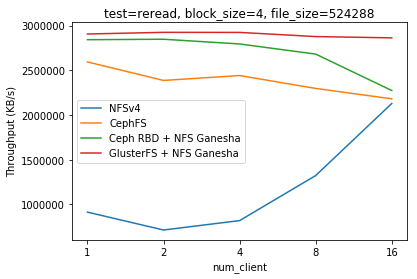

In [22]:
plot(dataset, x_axis='num_client', test='read', fixed=dict(block_size=4, file_size=512 * 1024))
plot(dataset, x_axis='num_client', test='reread', fixed=dict(block_size=4, file_size=512 * 1024))

##### 1.3 Random read/write

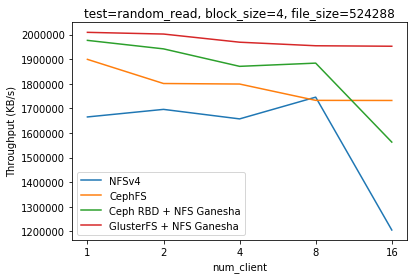

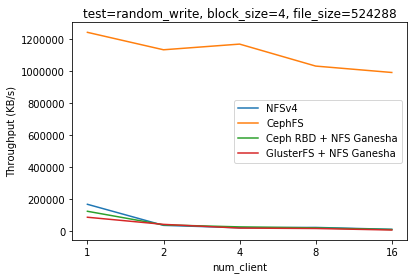

In [23]:
plot(dataset, x_axis='num_client', test='random_read', fixed=dict(block_size=4, file_size=512 * 1024))
plot(dataset, x_axis='num_client', test='random_write', fixed=dict(block_size=4, file_size=512 * 1024))

##### 1.4 fread/fwrite

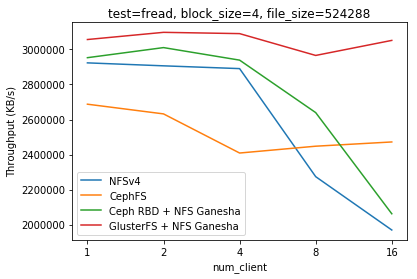

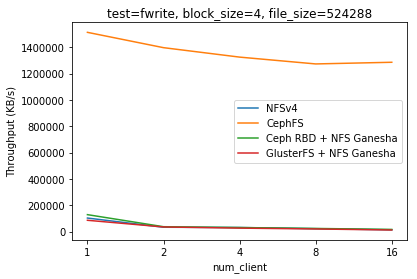

In [25]:
plot(dataset, x_axis='num_client', test='fread', fixed=dict(block_size=4, file_size=512 * 1024))
plot(dataset, x_axis='num_client', test='fwrite', fixed=dict(block_size=4, file_size=512 * 1024))